### Optimization of RF algorithm visulization

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

import helper_functions as hf

subsample_proportions = [0.0001, 0.00016, 0.00025, 0.0004, 0.00063, 
                         0.001, 0.0016, 0.0025, 0.004, 0.0063, 
                         0.01, 
                         0.1]

In [2]:
def get_file_lists(subsample_proportions, directory, hash='all'):
    """
    Returns a dictionary of lists of files for each subsampling proportion.
    """
    # initialize dictionary to subsample_proportions as keys and empty lists as values
    files = {subsample_proportion: [] for subsample_proportion in subsample_proportions}
    
    all_files = os.listdir(directory)
    for subsample_proportion in subsample_proportions:
        for file in all_files:
            if (f"sub{subsample_proportion}_" in file and f"features-{hash}" in file):
                files[subsample_proportion].append(directory + file)
    return files

Takes pretty long to run, better read it from the pickle file below

In [3]:
directory = "results/random_forest_optimization/"
file_lists = get_file_lists(subsample_proportions, directory)
compiled_metrics = {subsample_proportion: [] for subsample_proportion in subsample_proportions}

for sub in subsample_proportions:
    compiled_metrics[sub] = hf.compile_metrics(file_lists[sub], shuffle_correction=False)

# with open('results/RF_compiled_metrics.pickle', 'wb') as handle:
#     pickle.dump(compiled_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
# with open('results/RF_compiled_metrics.pickle', 'rb') as handle:
#     compiled_metrics = pickle.load(handle)

## Plotting of RF performance

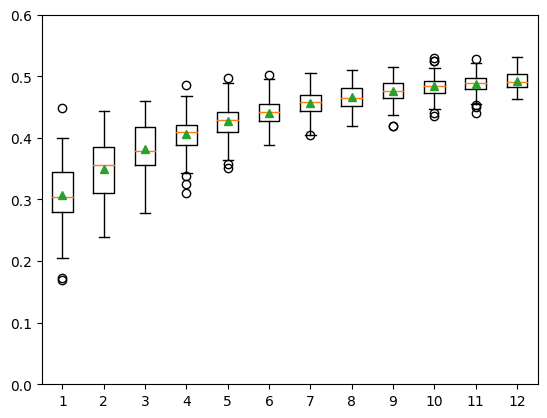

In [32]:
plt.boxplot([compiled_metrics[sub]["auc_first_gen"] for sub in subsample_proportions], showmeans=True)
plt.ylim(0, 0.6)
plt.show()

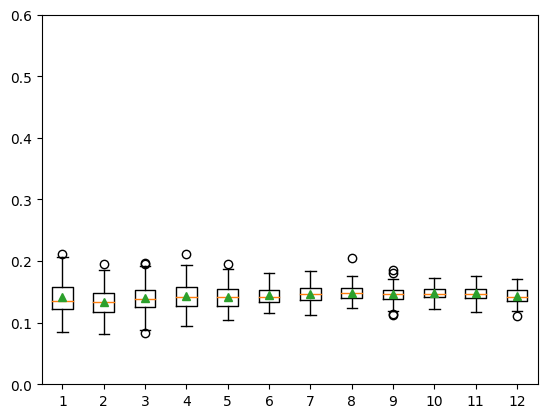

In [ ]:
plt.boxplot([compiled_metrics[sub]["auc_singles"] for sub in subsample_proportions], showmeans=True)
plt.ylim(0, 0.6)
plt.show()

## Jaccard score plots best/worst case scenario with uncertainty

In [41]:
directory = "results/random_forest_optimization/"
hash = 'all'

file_lists = get_file_lists(subsample_proportions, directory, hash)

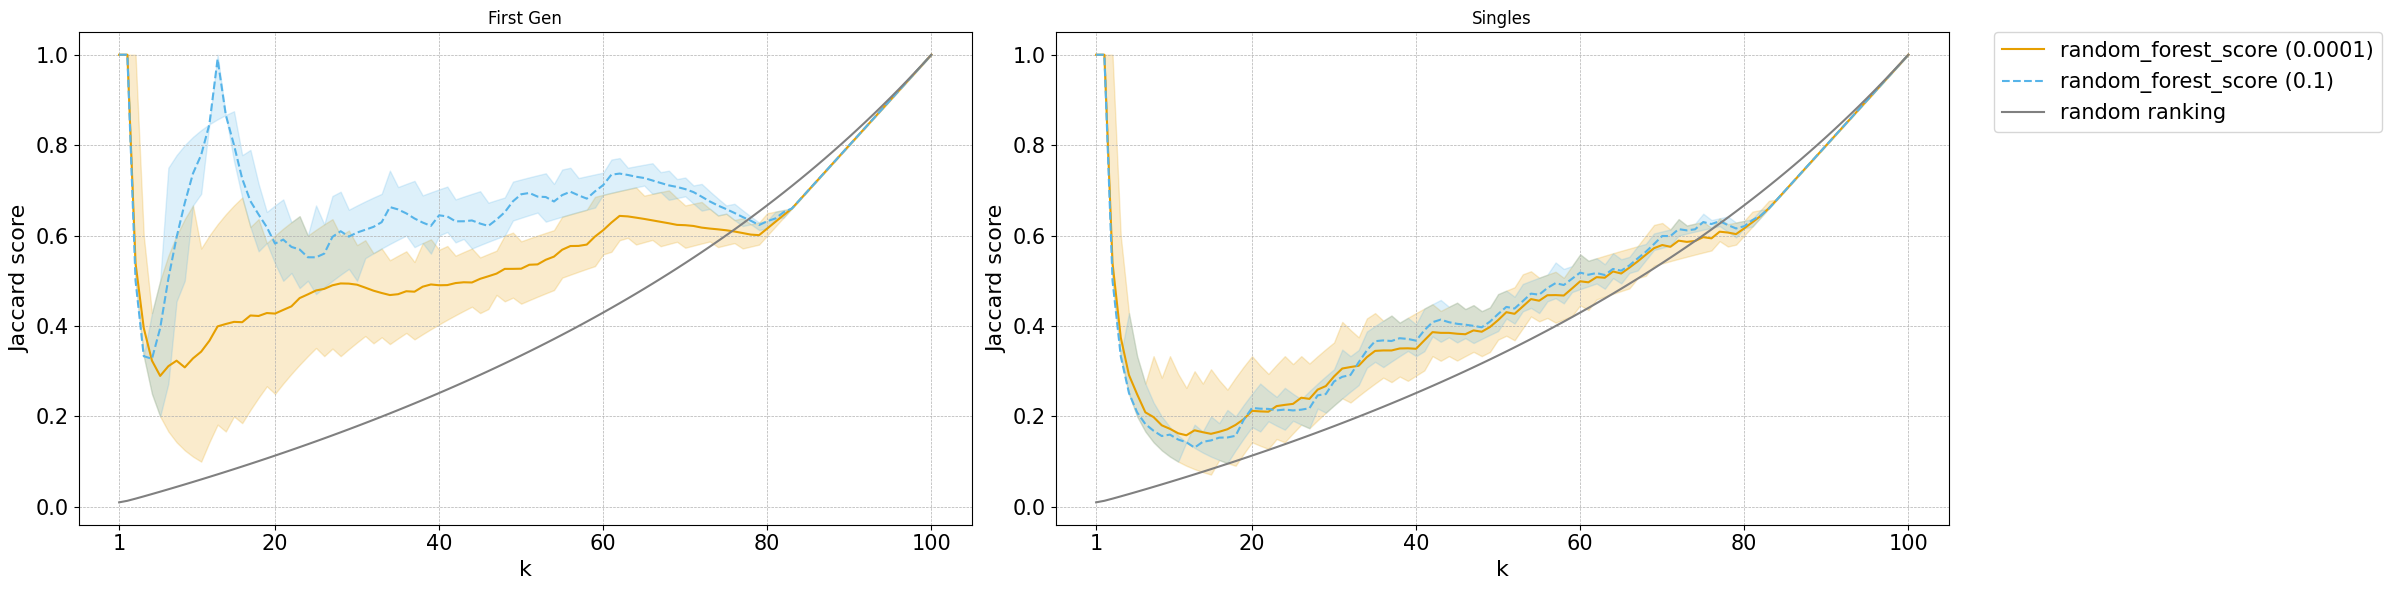

In [42]:
subs_to_plot = [0.0001, 0.1]
hf.plot_ranking_results([file_lists[sub] for sub in subs_to_plot])

In [43]:
directory = "results/random_forest_selected_features/"
hash = "77ee7ce5"

file_lists = get_file_lists(subsample_proportions, directory, hash)

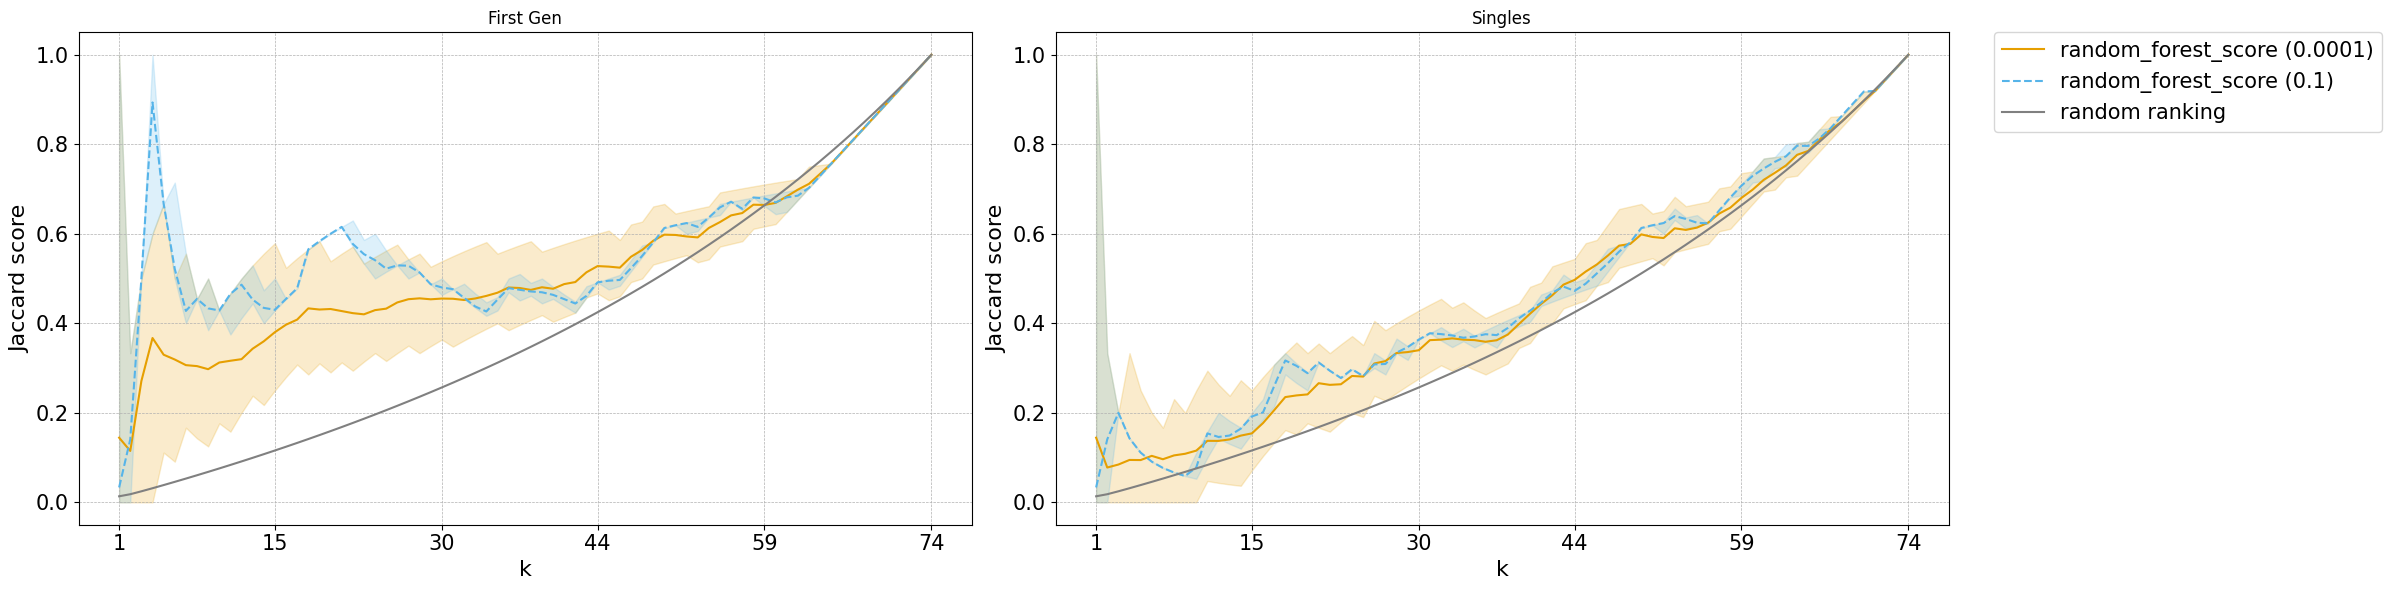

In [44]:
subs_to_plot = [0.0001, 0.1]
hf.plot_ranking_results([file_lists[sub] for sub in subs_to_plot])

## Prototype plots for logarithmic x axis

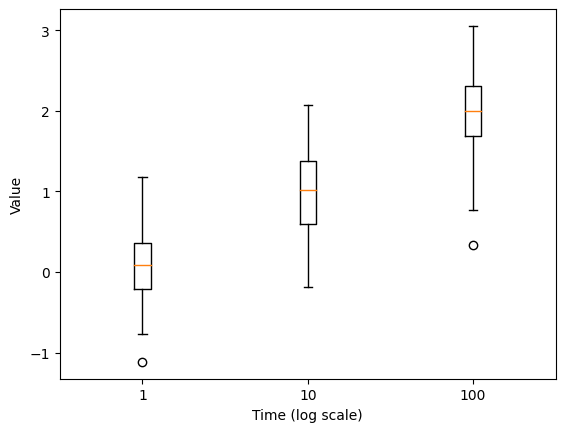

In [36]:
# Let's say we have three populations occurring at three different times
times = [1, 10, 100]
populations = [np.random.normal(loc=np.log10(i), scale=0.5, size=100) for i in times]

fig, ax = plt.subplots()

# Space boxplots evenly on a linear scale
linear_positions = range(1, len(times)+1)

for i, (time, population) in enumerate(zip(linear_positions, populations)):
    ax.boxplot(population, positions=[time], widths=0.1)

# Set x-axis labels to represent log scale
ax.set_xticks(linear_positions)
ax.set_xticklabels(times)

ax.set_xlabel('Time (log scale)')
ax.set_ylabel('Value')
plt.show()


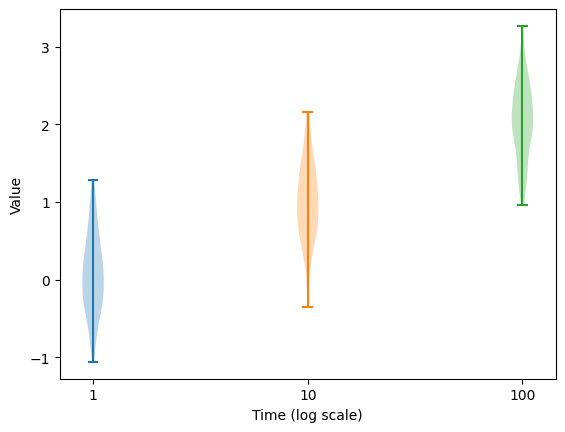

In [37]:
# Let's say we have three populations occurring at three different times
times = [1, 10, 100]
populations = [np.random.normal(loc=np.log10(i), scale=0.5, size=100) for i in times]

fig, ax = plt.subplots()

# Space violin plots evenly on a linear scale
linear_positions = range(1, len(times)+1)

for i, (time, population) in enumerate(zip(linear_positions, populations)):
    ax.violinplot(population, positions=[time], widths=0.1)

# Set x-axis labels to represent log scale
ax.set_xticks(linear_positions)
ax.set_xticklabels(times)

ax.set_xlabel('Time (log scale)')
ax.set_ylabel('Value')
plt.show()
